In [2]:
import os
import pandas as pd
import numpy as np
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# DÙNG SEABORN ĐỂ SET STYLE — KHÔNG DÙNG plt.style.use('seaborn-v0_11')
sns.set_theme(style="whitegrid", palette="husl")

In [3]:
MODEL_PATH = "./phobert-emotion-final"  # folder bạn lưu model sau khi train

# Load model và tokenizer
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)

# Lấy label mapping từ config (nếu có) hoặc tạo lại
id2label = model.config.id2label
label2id = model.config.label2id

print("✅ Model loaded successfully!")
print("Labels:", list(id2label.values()))

✅ Model loaded successfully!
Labels: ['Accepting', 'Anger', 'Disappointed', 'Disgust', 'Enjoyment', 'Fear', 'Highly Negative', 'Hopeless', 'Hurt', 'Indifferent', 'Loneliness', 'Lonely', 'Neutral', 'Other', 'Sadness', 'Spam', 'Surprise']


In [4]:
TEST_PATH = "UIT-VSMEC/test.csv"
test_df = pd.read_csv(TEST_PATH)

# Chuẩn hóa cột
test_df = test_df.rename(columns={"Sentence": "text", "Emotion": "label"})
test_df["label"] = test_df["label"].str.strip().str.title()  # đảm bảo nhất quán

print("Test set shape:", test_df.shape)
print("Label distribution:\n", test_df["label"].value_counts())

Test set shape: (693, 2)
Label distribution:
 label
Enjoyment    193
Disgust      132
Other        129
Sadness      116
Fear          46
Anger         40
Surprise      37
Name: count, dtype: int64


In [5]:
from datasets import Dataset

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True, max_length=128)

test_dataset = Dataset.from_pandas(test_df[["text", "label"]])
test_tokenized = test_dataset.map(tokenize_function, batched=True)

# Chuyển nhãn sang số
def encode_labels(example):
    example["label"] = label2id[example["label"]]
    return example

test_tokenized = test_tokenized.map(encode_labels)

# Định dạng cho PyTorch
test_tokenized.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

Map: 100%|██████████| 693/693 [00:00<00:00, 13732.52 examples/s]


In [6]:
# Tạo Trainer để đánh giá (không cần training_args phức tạp)
from transformers import Trainer

trainer = Trainer(model=model, tokenizer=tokenizer)

# Dự đoán
predictions = trainer.predict(test_tokenized)
preds = predictions.predictions.argmax(axis=1)
labels = predictions.label_ids

# Tính metrics tổng quát
acc = accuracy_score(labels, preds)
f1 = f1_score(labels, preds, average="weighted")

print(f"✅ Accuracy: {acc:.4f}")
print(f"✅ F1-score (weighted): {f1:.4f}")

✅ Accuracy: 0.5916
✅ F1-score (weighted): 0.5686


In [8]:
print("Epochs:", epochs)
print("Train loss:", train_loss)
print("Val loss:", val_loss)

Epochs: [1.146788990825688, 2.293577981651376]
Train loss: [1.6873, 1.176]
Val loss: [1.3186784982681274, 1.209537386894226, 1.1953214406967163]


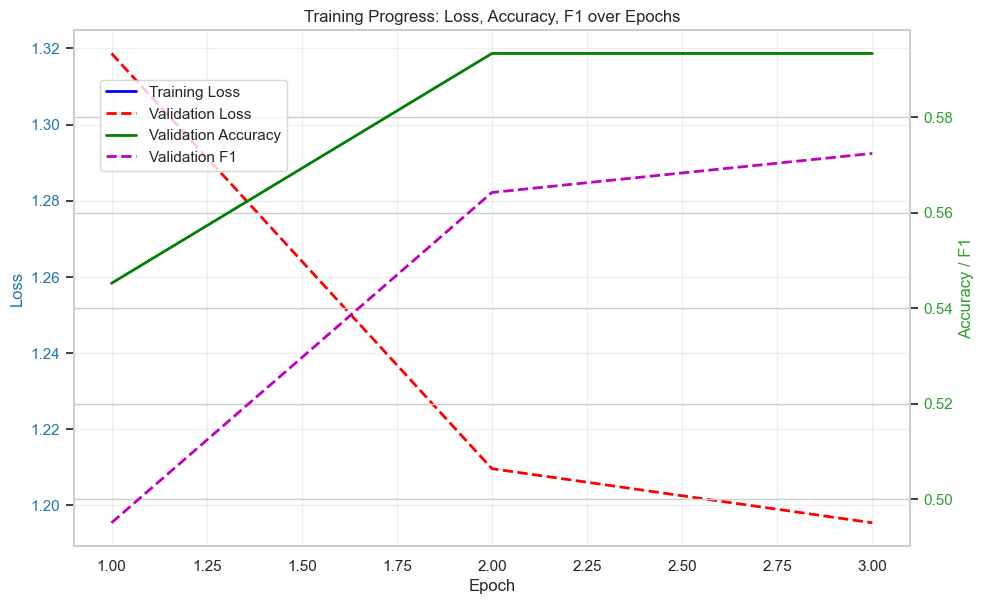

In [9]:
import json

LOG_PATH = "./phobert-emotion/checkpoint-1308/trainer_state.json"

if os.path.exists(LOG_PATH):
    with open(LOG_PATH, 'r') as f:
        trainer_state = json.load(f)

    logs = trainer_state['log_history']
    
    # Dùng dict để gom theo epoch
    epoch_data = {}
    
    for log in logs:
        if 'epoch' not in log:
            continue
        epoch = log['epoch']
        if epoch not in epoch_data:
            epoch_data[epoch] = {}
        
        # Lưu training loss (nếu có)
        if 'loss' in log:
            epoch_data[epoch]['train_loss'] = log['loss']
        # Lưu validation metrics (nếu có)
        if 'eval_loss' in log:
            epoch_data[epoch]['val_loss'] = log['eval_loss']
            epoch_data[epoch]['val_acc'] = log['eval_accuracy']
            epoch_data[epoch]['val_f1'] = log['eval_f1']
    
    # Sắp xếp theo epoch
    sorted_epochs = sorted(epoch_data.keys())
    epochs = []
    train_loss = []
    val_loss = []
    val_acc = []
    val_f1 = []
    
    for ep in sorted_epochs:
        data = epoch_data[ep]
        # Chỉ thêm nếu có đủ cả train và val (hoặc ít nhất val)
        if 'val_loss' in data:
            epochs.append(ep)
            train_loss.append(data.get('train_loss', None))  # có thể None
            val_loss.append(data['val_loss'])
            val_acc.append(data['val_acc'])
            val_f1.append(data['val_f1'])
    
    # Loại bỏ các điểm train_loss là None (nếu cần)
    # Nhưng để vẽ, ta cần xử lý None → thay bằng giá trị gần nhất hoặc bỏ qua
    # Đơn giản nhất: chỉ vẽ val_loss/val_acc/val_f1, và train_loss nếu có
    
    # Vẽ biểu đồ
    fig, ax1 = plt.subplots(figsize=(10, 6))

    color1 = 'tab:blue'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color=color1)
    # Vẽ train loss chỉ với các giá trị không None
    train_loss_clean = [x if x is not None else np.nan for x in train_loss]
    ax1.plot(epochs, train_loss_clean, 'b-', label='Training Loss', linewidth=2)
    ax1.plot(epochs, val_loss, 'r--', label='Validation Loss', linewidth=2)
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.grid(True, alpha=0.3)

    ax2 = ax1.twinx()
    color2 = 'tab:green'
    ax2.set_ylabel('Accuracy / F1', color=color2)
    ax2.plot(epochs, val_acc, 'g-', label='Validation Accuracy', linewidth=2)
    ax2.plot(epochs, val_f1, 'm--', label='Validation F1', linewidth=2)
    ax2.tick_params(axis='y', labelcolor=color2)

    fig.tight_layout()
    fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))
    plt.title('Training Progress: Loss, Accuracy, F1 over Epochs')
    plt.show()
else:
    print("⚠️ Không tìm thấy file trainer_state.json — không thể vẽ biểu đồ loss/accuracy.")

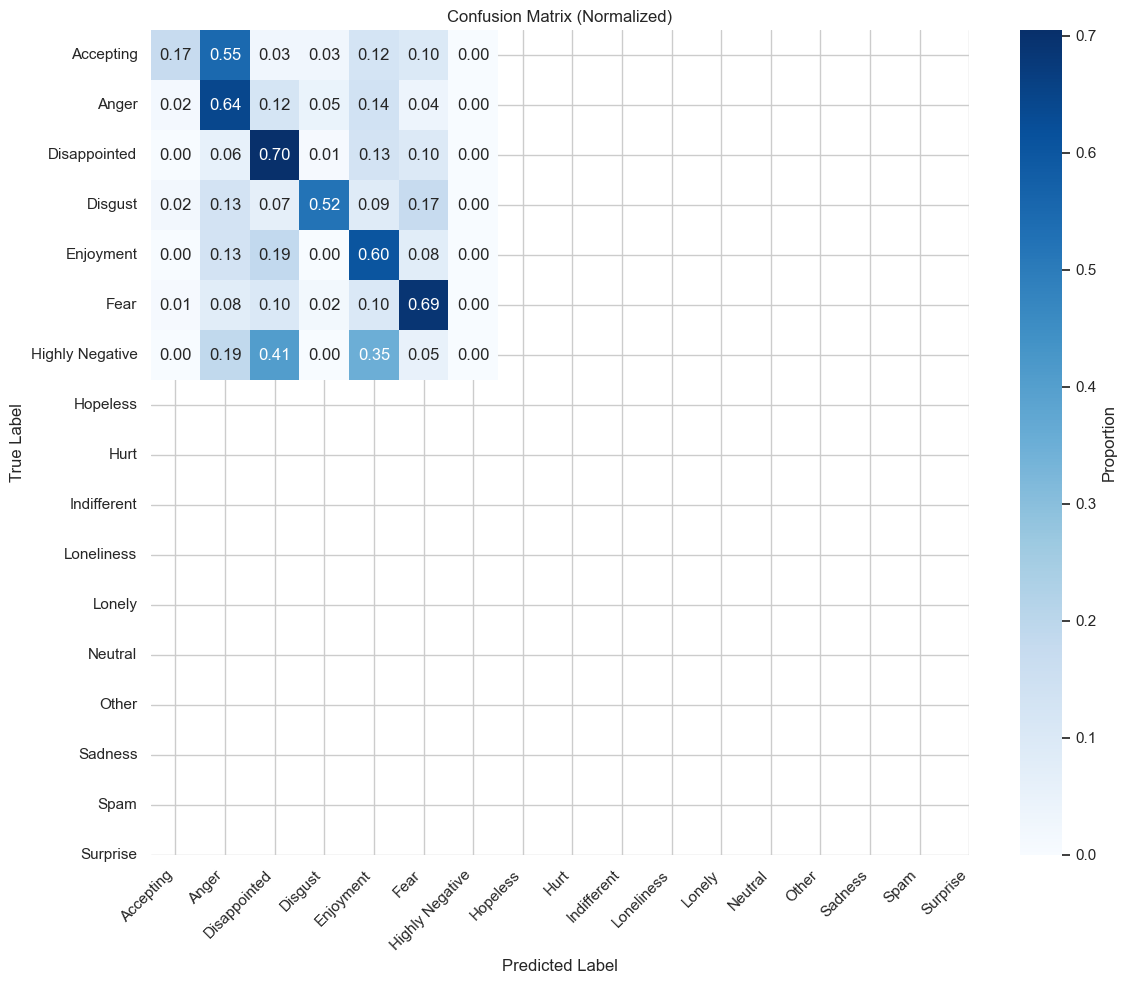

In [10]:
# Tạo confusion matrix
cm = confusion_matrix(labels, preds, normalize='true')

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=list(id2label.values()),
            yticklabels=list(id2label.values()),
            cbar_kws={'label': 'Proportion'})
plt.title('Confusion Matrix (Normalized)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [12]:
# Tạo classification report
# Lấy các lớp thực sự xuất hiện trong tập test
unique_label_ids = sorted(np.unique(np.concatenate([labels, preds])))
target_names = [id2label[i] for i in unique_label_ids]

# Tạo classification report
report = classification_report(
    labels, 
    preds, 
    labels=unique_label_ids,
    target_names=target_names, 
    digits=4
)

print("📊 Classification Report (per class):\n")
print(report)

📊 Classification Report (per class):

              precision    recall  f1-score   support

       Anger     0.6364    0.1750    0.2745        40
     Disgust     0.5414    0.6439    0.5882       132
   Enjoyment     0.6570    0.7047    0.6800       193
        Fear     0.6857    0.5217    0.5926        46
       Other     0.5032    0.6047    0.5493       129
     Sadness     0.6250    0.6897    0.6557       116
    Surprise     0.0000    0.0000    0.0000        37

    accuracy                         0.5916       693
   macro avg     0.5212    0.4771    0.4772       693
weighted avg     0.5666    0.5916    0.5686       693



In [13]:
# Lấy 5 câu ngẫu nhiên từ test set
sample_indices = np.random.choice(len(test_df), 5, replace=False)

for idx in sample_indices:
    text = test_df.iloc[idx]["text"]
    true_label = test_df.iloc[idx]["label"]
    
    # Tokenize
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    
    # Dự đoán
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=-1)
        pred_idx = torch.argmax(probs, dim=-1).item()
        pred_label = id2label[pred_idx]
        confidence = probs[0][pred_idx].item()

    print(f"📌 Câu: {text}")
    print(f"✅ Nhãn thật: {true_label}")
    print(f"✅ Nhãn dự đoán: {pred_label} (độ tin cậy: {confidence:.4f})")
    print("-" * 80)

📌 Câu: mấy thằng ở ngoài bình luận gặp tao tao xé mỏ từng đứa . cha mẹ đéo dạy để xã hội dạy nhé . còn phèn lắm
✅ Nhãn thật: Anger
✅ Nhãn dự đoán: Disgust (độ tin cậy: 0.4442)
--------------------------------------------------------------------------------
📌 Câu: cứu em nó với
✅ Nhãn thật: Sadness
✅ Nhãn dự đoán: Other (độ tin cậy: 0.5904)
--------------------------------------------------------------------------------
📌 Câu: đôi khi thích nói chuyện chỉ vì nói chuyện hợp và vì thích nói chuyện chứ thật ra chả phải yêu đương hay thích kiểu trai gái gì
✅ Nhãn thật: Other
✅ Nhãn dự đoán: Other (độ tin cậy: 0.5118)
--------------------------------------------------------------------------------
📌 Câu: mất dạy từ nhỏ , đẹp mặt khi bố mẹ nó đang ngồi xem tivi , cứ tưởng hay
✅ Nhãn thật: Disgust
✅ Nhãn dự đoán: Enjoyment (độ tin cậy: 0.7468)
--------------------------------------------------------------------------------
📌 Câu: chắc anh phải đáng yêu lắm luôn ý nhể 🤗🤗
✅ Nhãn thật: Enjoyment


In [14]:
# Tìm các mẫu bị dự đoán sai
wrong_preds = test_df.copy()
wrong_preds['predicted'] = [id2label[p] for p in preds]
wrong_preds['correct'] = wrong_preds['label'] == wrong_preds['predicted']

# Lọc ra các mẫu sai
errors = wrong_preds[~wrong_preds['correct']].reset_index(drop=True)

print(f"❌ Có {len(errors)} mẫu bị dự đoán sai trong {len(test_df)} mẫu test.")

# Hiển thị 5 mẫu đầu tiên
if len(errors) > 0:
    print("\n📝 Một vài ví dụ về lỗi:")
    for i in range(min(5, len(errors))):
        row = errors.iloc[i]
        print(f"Text: {row['text']}")
        print(f"True: {row['label']} | Predicted: {row['predicted']}")
        print("-" * 60)

❌ Có 283 mẫu bị dự đoán sai trong 693 mẫu test.

📝 Một vài ví dụ về lỗi:
Text: người ta có bạn bè nhìn vui thật
True: Sadness | Predicted: Enjoyment
------------------------------------------------------------
Text: cho nghỉ viêc mói đúng sao goi là kỷ luật
True: Surprise | Predicted: Disgust
------------------------------------------------------------
Text: kinh vãi 😡
True: Disgust | Predicted: Fear
------------------------------------------------------------
Text: nhà thì không xa lắm nhưng chưa bao giờ đi vì sợ bị đè bẹp luôn người =)))))
True: Fear | Predicted: Enjoyment
------------------------------------------------------------
Text: bố không thích nộp đấy mày thích ý kiến không
True: Anger | Predicted: Other
------------------------------------------------------------


In [15]:
# Lưu classification report vào file
with open("./evaluation_report.txt", "w") as f:
    f.write("=== Evaluation Report ===\n")
    f.write(f"Accuracy: {acc:.4f}\n")
    f.write(f"F1-score: {f1:.4f}\n\n")
    f.write("Classification Report:\n")
    f.write(report)

print("✅ Báo cáo đánh giá đã được lưu vào ./evaluation_report.txt")

✅ Báo cáo đánh giá đã được lưu vào ./evaluation_report.txt


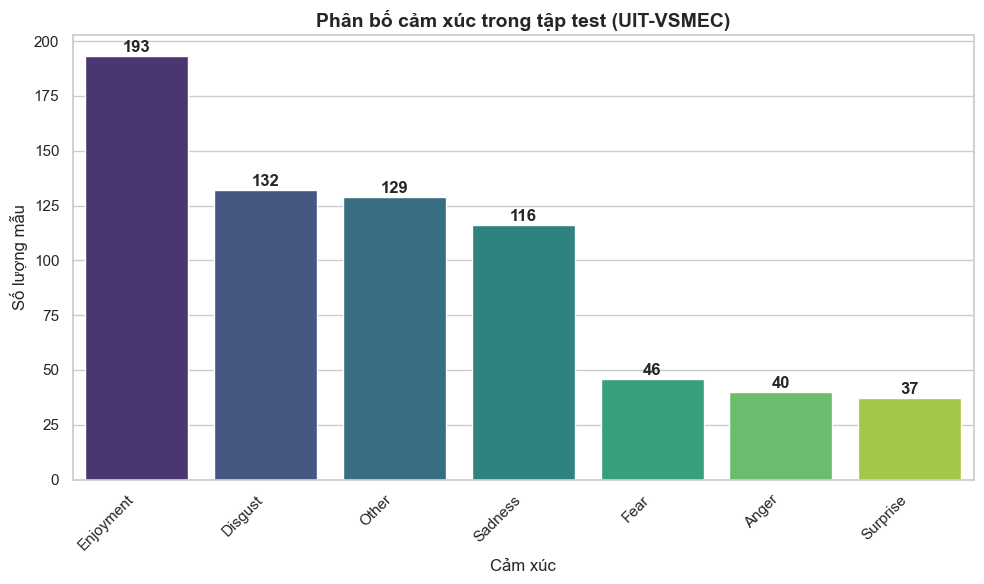

In [16]:
plt.figure(figsize=(10, 6))
label_counts = test_df['label'].value_counts()
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.title("Phân bố cảm xúc trong tập test (UIT-VSMEC)", fontsize=14, weight='bold')
plt.xlabel("Cảm xúc", fontsize=12)
plt.ylabel("Số lượng mẫu", fontsize=12)
plt.xticks(rotation=45, ha='right')
for i, v in enumerate(label_counts.values):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

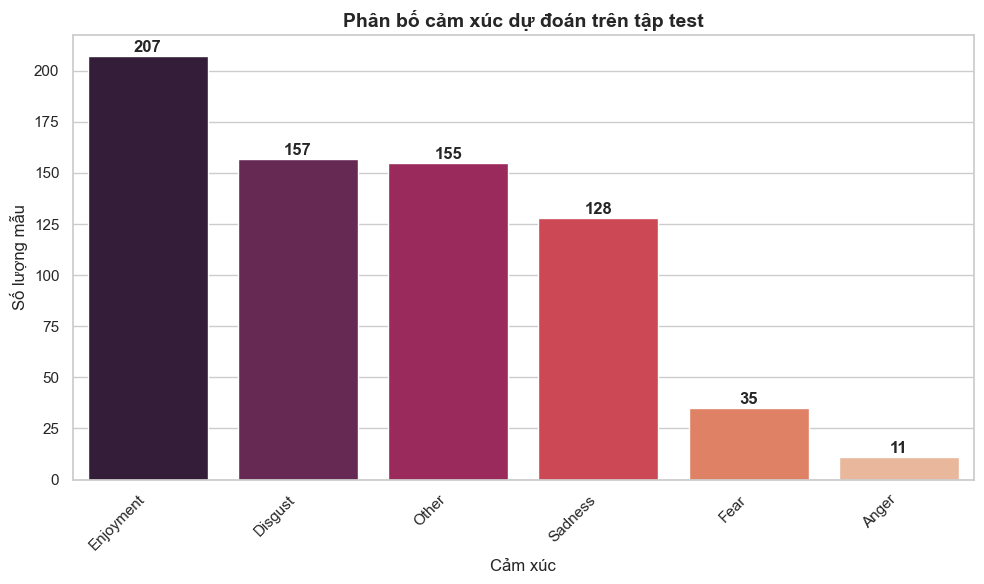

In [17]:
plt.figure(figsize=(10, 6))
pred_labels = [id2label[p] for p in preds]
pred_counts = pd.Series(pred_labels).value_counts()
sns.barplot(x=pred_counts.index, y=pred_counts.values, palette="rocket")
plt.title("Phân bố cảm xúc dự đoán trên tập test", fontsize=14, weight='bold')
plt.xlabel("Cảm xúc", fontsize=12)
plt.ylabel("Số lượng mẫu", fontsize=12)
plt.xticks(rotation=45, ha='right')
for i, v in enumerate(pred_counts.values):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

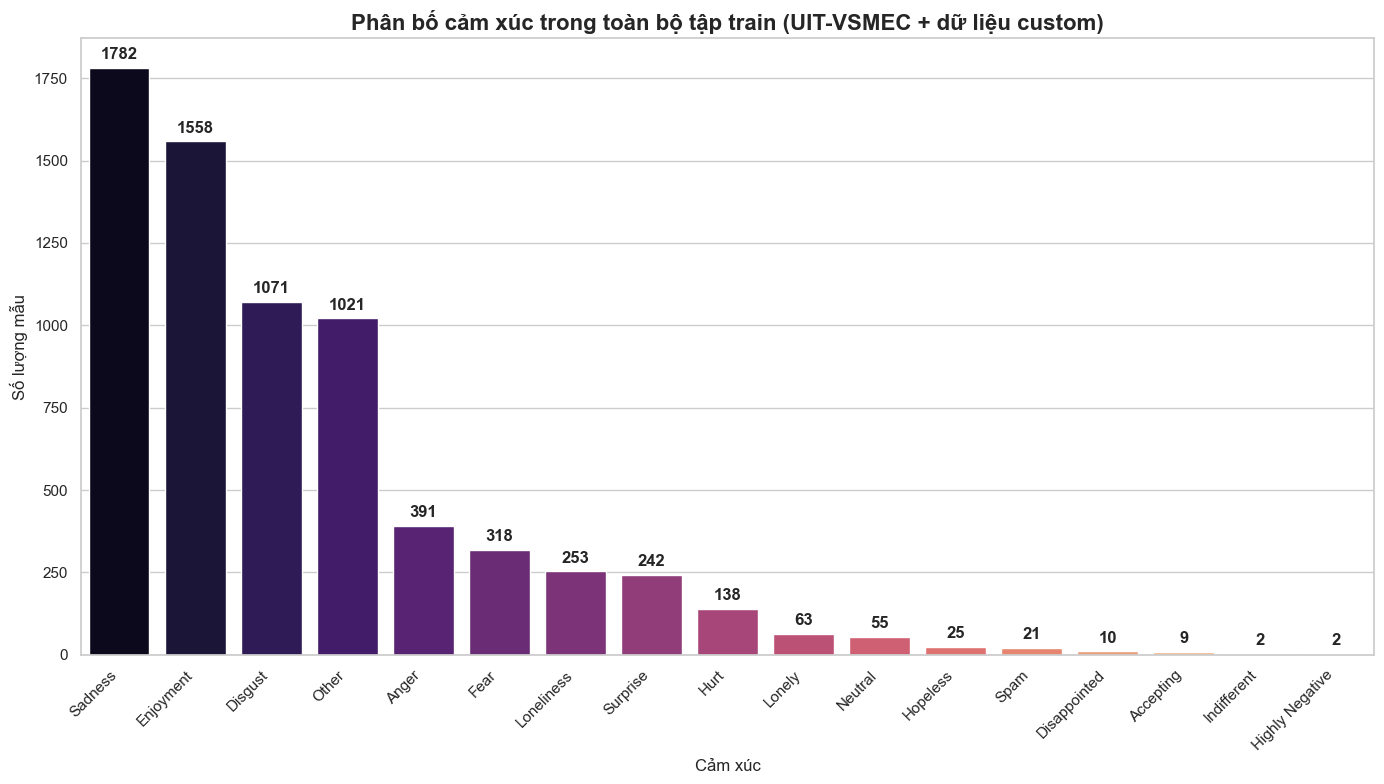

✅ Tổng số mẫu train: 6961
✅ Số lớp cảm xúc: 17

Top 5 lớp nhiều nhất:
label
Sadness      1782
Enjoyment    1558
Disgust      1071
Other        1021
Anger         391
Name: count, dtype: int64

Top 5 lớp ít nhất:
label
Spam               21
Disappointed       10
Accepting           9
Indifferent         2
Highly Negative     2
Name: count, dtype: int64


In [18]:
# Đường dẫn
UIT_PATH = "UIT-VSMEC"
DATA_PATH = "data"

# Load UIT-VSMEC train
train_uit = pd.read_csv(os.path.join(UIT_PATH, "train.csv"))
train_uit = train_uit.rename(columns={"Sentence": "text", "Emotion": "label"})
train_uit["label"] = train_uit["label"].str.strip().str.title()

# Load dữ liệu custom
data1 = pd.read_csv(os.path.join(DATA_PATH, "data.csv")).rename(columns={"Comment": "text", "Emotion": "label"})
data2 = pd.read_csv(os.path.join(DATA_PATH, "augmented_dataset.csv"))[["text", "emotion"]].rename(columns={"emotion": "label"})
data3 = pd.read_csv(os.path.join(DATA_PATH, "temp_augmented.csv"))[["text", "emotion"]].rename(columns={"emotion": "label"})

# Chuẩn hóa nhãn
for df in [data1, data2, data3]:
    df["label"] = df["label"].str.strip().str.title()

# Gộp lại
custom_train = pd.concat([data1, data2, data3], ignore_index=True)
full_train = pd.concat([train_uit, custom_train], ignore_index=True)

# Vẽ biểu đồ
plt.figure(figsize=(14, 8))
label_counts = full_train['label'].value_counts()
sns.barplot(x=label_counts.index, y=label_counts.values, palette="magma")
plt.title("Phân bố cảm xúc trong toàn bộ tập train (UIT-VSMEC + dữ liệu custom)", fontsize=16, weight='bold')
plt.xlabel("Cảm xúc", fontsize=12)
plt.ylabel("Số lượng mẫu", fontsize=12)
plt.xticks(rotation=45, ha='right')
for i, v in enumerate(label_counts.values):
    plt.text(i, v + max(label_counts.values)*0.01, str(v), ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

# In tổng quan
print(f"✅ Tổng số mẫu train: {len(full_train)}")
print(f"✅ Số lớp cảm xúc: {full_train['label'].nunique()}")
print("\nTop 5 lớp nhiều nhất:")
print(label_counts.head())
print("\nTop 5 lớp ít nhất:")
print(label_counts.tail())